In [3]:
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import random
from past.builtins import xrange
import pickle 
import numpy as np
import os
import torch
from torch import nn
import sys
import os
import torch.optim as optim
import csv

import datetime
import os
import threading
sys.path.append('../../')
# almost similar to the original implementations

losslist=[]

class Dataset():
    """docstring for Dataset"""
    def __init__(self,train_data=True,userhistory=[]):
        super(Dataset, self).__init__()
        self.dataset = "mv"
        self.model_type = "PW"
        self.band_size = 20
        #load the data
        #data_filename = os.path.join(args.data_folder, args.dataset+'.pkl')
        if train_data:
            f = open("movie.pkl", 'rb')
            data_behavior = pickle.load(f) # time and user behavior
            del data_behavior[0]
            tmp=[]
            # usernum=300
            # for i in range(usernum):
            #     tmp.append(data_behavior[i])
            f.close()
        else:
            tmp=userhistory

        data_behavior=tmp
        #실구현시에는 movie의 개수임.
        #그냥 movie를 원핫 벡터화했는데요..? 그러니까 movie1=[1.0,,0,0,0,0],movie2=[0.1,,0,0,0,0]
        #item_feature = pickle.load(f) # identity matrix
        item_feature = np.eye(3952)


        self.size_item = len(item_feature)
        self.size_user = len(data_behavior)
        self.f_dim = len(item_feature[0])

        # load the index fo train,test,valid split 
        if train_data:
            self.train_user = range(int(usernum*0.7))
            self.vali_user = range(int(usernum*0.7),int(usernum*0.8))
            self.test_user = range(int(usernum*0.8),usernum)
        else:
            self.train_user = 0
            self.vali_user = 0
            self.test_user = 0

        # process the data

        # get the most no of suggetion for an individual at a time
        # 영화 추천한 집합 중에서 가장 긴 것을 kmax라 한다.
        k_max = 0
        for d_b in data_behavior:
            for disp in d_b[1]:
                k_max = max(k_max, len(disp))

        self.data_click = [[] for x in xrange(self.size_user)]
        #유저가 본 영화 목록(중복을 없애서)
        self.data_disp = [[] for x in xrange(self.size_user)]
        self.data_time = np.zeros(self.size_user, dtype=np.int)
        self.data_news_cnt = np.zeros(self.size_user, dtype=np.int)
        self.feature = [[] for x in xrange(self.size_user)]
        self.feature_click = [[] for x in xrange(self.size_user)]
            #유저 100명에 대해서
        for user in xrange(self.size_user):
            print(user)
            # (1) count number of clicks
            click_t = 0
            num_events = len(data_behavior[user][1])
            click_t += num_events
            self.data_time[user] = click_t
            # (2)
            #news_dict에는, movie가 인덱싱 되어있음
            news_dict = {}
            #feature click에 있는 리스트의 size는 [click_t,self.f_dim]이다(클릭이 15, f_dim이 3952)
            self.feature_click[user] = np.zeros([click_t, self.f_dim])
            click_t = 0
            for event in xrange(num_events):
                #그러니까, list에 있는 것중에 실제로 뽑힌 것을 찾는 과정임
                disp_list = data_behavior[user][1][event]
                #print(len(disp_list))
                #[1198, 1210, 1217, 2717, 1293]
                pick_id = data_behavior[user][2][event]
                #뭐 뽑았니
                #print(pick_id)  1293

                for id in disp_list:
                    #movie의 인덱싱
                    if id not in news_dict:
                        news_dict[id] = len(news_dict)  # for each user, movie id start from 0
                if pick_id:
                    id = pick_id
                    #pick_id가 있다면(무조건 있음) 유저에, click_t(idx),news_dict(새로 인덱싱한거)
                    self.data_click[user].append([click_t, news_dict[id]])
                    self.feature_click[user][click_t] = item_feature[id-1]
                for idd in disp_list:
                    self.data_disp[user].append([click_t, news_dict[idd]])
                click_t += 1  # splitter a event with 2 clickings to 2 events
            #data_news_cnt[useridx]에는 disp_list의 총합이되, 중복제거
            self.data_news_cnt[user] = len(news_dict)
            #print("news_dict",len(news_dict))
            # feature[user]=유저가 본 무비데이터xf_dim
            self.feature[user] = np.zeros([self.data_news_cnt[user], self.f_dim])
            #item_feature에서 값 찾아서 movie매칭
            #[user][news_dict[id](id들어온대로 idx한거)]
            for id in news_dict:
                self.feature[user][news_dict[id]] = item_feature[id-1]
            self.feature[user] = self.feature[user].tolist()
            self.feature_click[user] = self.feature_click[user].tolist()
        self.max_disp_size = k_max
        
    def random_split_user(self):
        # dont think this one is really necessary if the initial split is random enough
        num_users = len(self.train_user) + len(self.vali_user) + len(self.test_user)
        shuffle_order = np.arange(num_users)
        np.random.shuffle(shuffle_order)
        self.train_user = shuffle_order[0:len(self.train_user)].tolist()
        self.vali_user = shuffle_order[len(self.train_user):len(self.train_user)+len(self.vali_user)].tolist()
        self.test_user = shuffle_order[len(self.train_user)+len(self.vali_user):].tolist()

    def data_process_for_placeholder(self, user_set):
        #print ("user_set",user_set)
        if self.model_type == 'PW':
            
            sec_cnt_x = 0
            news_cnt_short_x = 0
            news_cnt_x = 0
            click_2d_x = []
            disp_2d_x = []

            tril_indice = []
            tril_value_indice = []

            disp_2d_split_sec = []
            feature_clicked_x = []

            disp_current_feature_x = []
            click_sub_index_2d = []

            # started with the validation set
            #[703, 713, 723, 733, 743, 753, 763, 773, 783, 793, 803, 813, 823, 833, 843, 853, 863, 873, 883, 893, 903, 913, 923, 933, 943, 953, 963, 973, 983, 993, 1003, 1013, 1023, 1033, 1043, 1053]
            #user_set = [703]
            for u in user_set:
                t_indice = []
                #print(self.data_time[u]-1)
                #19랑 얼마나 클릭했냐를 체크하여 짧은 쪽 선택
                #데이터가 19넘으면 자르고, 19이하면 채우는 매커니즘
                for kk in xrange(min(self.band_size-1, self.data_time[u]-1)):
                    #(데이터 시간[u]-(kk+1))를 lambda로 반환
                    # 0,kk=0이면 (0+0+1,0)
                    #[1,0]....[6,0..]
                    t_indice += map(lambda x: [x + kk+1 + sec_cnt_x, x + sec_cnt_x], np.arange(self.data_time[u] - (kk+1)))
              #  for t in range(len(t_indice)):
              #      print(t_indice[t])
              #  print (len(t_indice)) #[] for 703
              #  quit()
                tril_indice += t_indice
                tril_value_indice += map(lambda x: (x[0] - x[1] - 1), t_indice)
               # print ("THE Click data is ",self.data_click[u]) #THE Click data is  [[0, 0], [1, 8], [2, 14]] for u =15
                click_2d_tmp = map(lambda x: [x[0] + sec_cnt_x, x[1]], self.data_click[u])
                click_2d_tmp = list(click_2d_tmp)
               # print (len(list(click_2d_tmp)))
                #print (list(click_2d_tmp))
                click_2d_x += click_2d_tmp
                #print ("tenp is ",click_2d_x,list(click_2d_tmp))  # [[0, 0], [1, 8], [2, 14]] for u15
                #print ("dispaly data is ", self.data_disp[u])
                #[0,0]
                

                disp_2d_tmp = map(lambda x: [x[0] + sec_cnt_x, x[1]], self.data_disp[u])
                disp_2d_tmp = list(disp_2d_tmp)
                #y=[]
                #y+=disp_2d_tmp
                #print (disp_2d_tmp, click_2d_tmp)
                click_sub_index_tmp = map(lambda x: disp_2d_tmp.index(x), (click_2d_tmp))
                click_sub_index_tmp = list(click_sub_index_tmp)
                #print ("the mess is ",click_sub_index_tmp)
                click_sub_index_2d += map(lambda x: x+len(disp_2d_x), click_sub_index_tmp)
                #print ("click_sub_index_2d",click_sub_index_2d)
                disp_2d_x += disp_2d_tmp
                #print ("disp_2d_x",disp_2d_x) # [[0, 0]]
                #sys.exit()
                disp_2d_split_sec += map(lambda x: x[0] + sec_cnt_x, self.data_disp[u])

                sec_cnt_x += self.data_time[u]
                news_cnt_short_x = max(news_cnt_short_x, self.data_news_cnt[u])
                news_cnt_x += self.data_news_cnt[u]
                disp_current_feature_x += map(lambda x: self.feature[u][x], [idd[1] for idd in self.data_disp[u]])
                feature_clicked_x += self.feature_click[u]

                out1 ={}
                out1['click_2d_x']=click_2d_x
                out1['disp_2d_x']=disp_2d_x
                out1['disp_current_feature_x']=disp_current_feature_x
                out1['sec_cnt_x']=sec_cnt_x
                out1['tril_indice']=tril_indice
                out1['tril_value_indice']=tril_value_indice
                out1['disp_2d_split_sec']=disp_2d_split_sec
                out1['news_cnt_short_x']=news_cnt_short_x
                out1['click_sub_index_2d']=click_sub_index_2d
                out1['feature_clicked_x']=feature_clicked_x
            # print ("out",out1['tril_value_indice'])
#             # sys.exit()
#             with open('user.pickle','wb') as fw:
#                 pickle.dump(out1, fw)
            return out1


    def prepare_validation_data(self, num_sets, v_user):

        if self.model_type == 'PW':
            vali_thread_u = [[] for _ in xrange(num_sets)]
            click_2d_v = [[] for _ in xrange(num_sets)]
            disp_2d_v = [[] for _ in xrange(num_sets)]
            feature_v = [[] for _ in xrange(num_sets)]
            sec_cnt_v = [[] for _ in xrange(num_sets)]
            tril_ind_v = [[] for _ in xrange(num_sets)]
            tril_value_ind_v = [[] for _ in xrange(num_sets)]
            disp_2d_split_sec_v = [[] for _ in xrange(num_sets)]
            feature_clicked_v = [[] for _ in xrange(num_sets)]
            news_cnt_short_v = [[] for _ in xrange(num_sets)]
            click_sub_index_2d_v = [[] for _ in xrange(num_sets)]
            for ii in xrange(len(v_user)):
                vali_thread_u[ii % num_sets].append(v_user[ii])
            for ii in xrange(num_sets):
                out=self.data_process_for_placeholder(vali_thread_u[ii])
                # print ("out_val",out['tril_indice'])
                # sys.exit()

                click_2d_v[ii], disp_2d_v[ii], feature_v[ii], sec_cnt_v[ii], tril_ind_v[ii], tril_value_ind_v[ii], \
                disp_2d_split_sec_v[ii], news_cnt_short_v[ii], click_sub_index_2d_v[ii], feature_clicked_v[ii] = out['click_2d_x'], \
                out['disp_2d_x'], \
                out['disp_current_feature_x'], \
                out['sec_cnt_x'], \
                out['tril_indice'], \
                out['tril_value_indice'], \
                out['disp_2d_split_sec'], \
                out['news_cnt_short_x'], \
                out['click_sub_index_2d'], \
                out['feature_clicked_x']

            out2={}
            out2['vali_thread_u']=vali_thread_u 
            out2['click_2d_v']=click_2d_v 
            out2['disp_2d_v']=disp_2d_v 
            out2['feature_v']=feature_v 
            out2['sec_cnt_v']=sec_cnt_v 
            out2['tril_ind_v']=tril_ind_v 
            out2['tril_value_ind_v']=tril_value_ind_v 
            out2['disp_2d_split_sec_v']=disp_2d_split_sec_v 
            out2['news_cnt_short_v']=news_cnt_short_v 
            out2['click_sub_index_2d_v']=click_sub_index_2d_v 
            out2['feature_clicked_v']=feature_clicked_v
            return out2

class UserModelPW(nn.Module):
    """docstring for UserModelPW"""

    def __init__(self, f_dim):
        super(UserModelPW, self).__init__()
        self.f_dim = 3952
        # self.placeholder = {}
        self.hidden_dims = '64-64'
        self.lr = 0.001
        self.pw_dim = 4
        self.band_size = 20
        self.mlp_model = self.mlp(19760, self.hidden_dims, 1, 1e-3, act_last=False)
        self.u_disps=[]

    def mlp(self, x_shape, hidden_dims, output_dim, sd, act_last=False):
        hidden_dims = tuple(map(int, hidden_dims.split("-")))
        # print ("hidden_dims",hidden_dims)
        # print ("imp is",x)
        # print (x.shape,x.dtype)
        cur = x_shape
        main_mod = nn.Sequential()
        for i, h in enumerate(hidden_dims):
            main_mod.add_module('Linear-{0}'.format(i), torch.nn.Linear(cur, h))
            main_mod.add_module('act-{0}'.format(i), nn.ELU())
            cur = h

        if act_last:
            main_mod.add_module("Linear_last", torch.nn.Linear(cur, output_dim))
            main_mod.add_module("act_last", nn.ELU())
            return main_mod
        else:
            main_mod.add_module("linear_last", torch.nn.Linear(cur, output_dim))
            return main_mod

    def forward(self, inputs, is_train=False, index=None):
        # input is a dictionaty 
        if is_train == True:

            disp_current_feature = torch.tensor(inputs['disp_current_feature_x'])
            Xs_clicked = torch.tensor(inputs['feature_clicked_x'])
            item_size = torch.tensor(inputs['news_cnt_short_x'])
            section_length = torch.tensor(inputs['sec_cnt_x'])
            click_values = torch.tensor(np.ones(len(inputs['click_2d_x']), dtype=np.float32))
            click_indices = torch.tensor(inputs['click_2d_x'])
            disp_indices = torch.tensor(np.array(np.int64(inputs['disp_2d_x'])))
            disp_2d_split_sec_ind = torch.tensor(inputs['disp_2d_split_sec'])
            cumsum_tril_indices = torch.tensor(np.int64(inputs['tril_indice']))
            cumsum_tril_value_indices = torch.tensor(np.array(inputs['tril_value_indice'], dtype=np.int64))
            click_2d_subindex = torch.tensor(inputs['click_sub_index_2d'])

        else:
            # define the inputs for val/tst here
            # print ("input_val",inputs)
            disp_current_feature = torch.tensor(inputs['feature_v'][index])
            Xs_clicked = torch.tensor(inputs['feature_clicked_v'][index])
            item_size = torch.tensor(inputs['news_cnt_short_v'][index])
            section_length = torch.tensor(inputs['sec_cnt_v'][index])
            click_values = torch.tensor(np.ones(len(inputs['click_2d_v'][index]), dtype=np.float32))
            click_indices = torch.tensor(inputs['click_2d_v'][index])
            disp_indices = torch.tensor(np.array(np.int64(inputs['disp_2d_v'][index])))
            disp_2d_split_sec_ind = torch.tensor(inputs['disp_2d_split_sec_v'][index])
            cumsum_tril_indices = torch.tensor(np.int64(inputs['tril_ind_v'][index]))
            cumsum_tril_value_indices = torch.tensor(np.array(inputs['tril_value_ind_v'][index], dtype=np.int64))
            click_2d_subindex = torch.tensor(inputs['click_sub_index_2d_v'][index])

        #feature_v가 9352 torch.Size([9352, 3952])
        #유저들이 간단히 생각해서 본 영화의 총합이 9352개라는 뜻 (유저끼리는 중복있음)
       # print(disp_current_feature.shape)
        #2390,3952  torch.Size([2390, 3952])
       # print(Xs_clicked.shape)
        #null
       # print(item_size.shape)
        #null
       # print(section_length.shape)
        #click value torch.Size([2390])
       # print(click_values.shape)
        #torch.Size([9352, 2])
       # print(disp_indices.shape)
        #torch.Size([9352, 3952])
       # print(disp_2d_split_sec_ind.shape)
       # torch.Size([33865, 2])
       # print(cumsum_tril_indices.shape)
        #u_disp.shape torch.Size([9352, 1])
       # print(cumsum_tril_value_indices.shape)
        denseshape = [section_length, item_size]  # this wont work

        click_history = [[] for _ in xrange(self.pw_dim)]
      #  print("slice")
        # pw
        for ii in xrange(self.pw_dim):
            position_weight = torch.ones(size=[self.band_size]).to(dtype=torch.float64) * 0.0001
            # print (position_weight,cumsum_tril_value_indices)

            cumsum_tril_value = position_weight[cumsum_tril_value_indices]
            # tf.gather(position_weight, self.placeholder['cumsum_tril_value_indices'])
          #  print ("cumsum_tril_indices",cumsum_tril_indices)
           # print ("cumsum_tril_value",cumsum_tril_value)

            cumsum_tril_matrix = torch.sparse.FloatTensor(cumsum_tril_indices.t(), cumsum_tril_value,
                                                          [section_length, section_length]).to_dense()
            # print ("cumsum_tril_matrix",cumsum_tril_matrix)
            # print ("Xs_clicked",Xs_clicked.dtype)
            # feature 행렬곱하는 부분

            click_history[ii] = torch.matmul(cumsum_tril_matrix, Xs_clicked.to(dtype=torch.float64))  # Xs_clicked: section by _f_dim

        concat_history = torch.cat(click_history, axis=1)
        #print("history: ",concat_history,concat_history.shape)
        #[1,x]
        disp_history_feature = concat_history[disp_2d_split_sec_ind]
        
        # (4) combine features
        #[갯수,19760]
        concat_disp_features = torch.reshape(torch.cat([disp_history_feature, disp_current_feature], axis=1),
                                             [-1, self.f_dim * self.pw_dim + self.f_dim])

        #  print(len(concat_disp_features))
       # print("concat ",concat_disp_features.shape)
        # (5) compute utility
        # print ("the in pu t shape s ",concat_disp_features.shape)
        # reward
        u_disp = self.mlp_model(concat_disp_features.float())
       # print("u_disp ",u_disp.shape)
        # net.apply(init_weights,sdv)
        # (5) 백터로 나옴. 값은
        # user가 본 영화 길이가 나오는듯
        #print(u_disp)
        exp_u_disp = torch.exp(u_disp)
        #reward [1, 2,3,4,5]
        #[e^1,e^2,e^3,e^4,e^5]     [[1,2,3/4,5,6]]
        # #torch exp
        # [1,1,2,1,1, 1,1,1,1, 1,1,1]
        # [0,0,0,0,0  1 1 1 1 ,2,2,2]->[5,4,3]
       # print(disp_2d_split_sec_ind)
        sum_exp_disp_ubar_ut = segment_sum(exp_u_disp, disp_2d_split_sec_ind)
        #U_disp에 segment_sum을 함으로서, 
      #  print ("sum_exp_disp_ubar_ut ",sum_exp_disp_ubar_ut)
       # print(click_2d_subindex)
        sum_click_u_bar_ut = u_disp[click_2d_subindex]
        #reward에서 subindex만을 고른다(실제 선택한 값의 reward)
       # print(sum_click_u_bar_ut)
        # (6) loss and precision
        #print ("click_values",click_values.shape)
        #print ("click_indices",click_indices.shape)
       # print ("click_indices",click_indices)
      #  print ("denseshape",denseshape.shape)
        #error size 1
        click_tensor = torch.sparse.FloatTensor(click_indices.t(), click_values, denseshape).to_dense()
        #print("click tensor",click_tensor.shape)
        click_cnt = click_tensor.sum(1)
        #reward
        loss_sum = torch.sum(- sum_click_u_bar_ut + torch.log(sum_exp_disp_ubar_ut ))#+1
        #
        event_cnt = torch.sum(click_cnt)
        loss = loss_sum / event_cnt
       # print(torch.log(sum_exp_disp_ubar_ut + 1))

        exp_disp_ubar_ut = torch.sparse.FloatTensor(disp_indices.t(), torch.reshape(exp_u_disp, (-1,)), denseshape)
        
        #print("exp_disp_ubar_ut",exp_disp_ubar_ut.shape)
        dense_exp_disp_util = exp_disp_ubar_ut.to_dense()
        argmax_click = torch.argmax(click_tensor, dim=1)
        argmax_disp = torch.argmax(dense_exp_disp_util, dim=1)
        # 최고 2개 리턴
        top_2_disp = torch.topk(dense_exp_disp_util, k=2, sorted=False)[1]

        # print ("argmax_click",argmax_click.shape)
        # for i in argmax_click:
        #     print(i)
        # print ("argmax_disp",argmax_disp.shape)
        # print ("argmax_disp",argmax_disp)
        # ("top_2_disp",top_2_disp,top_2_disp.shape)
        #print("argmax_disp",argmax_disp,argmax_disp.shape)
        #sys.exit()
        precision_1_sum = torch.sum((torch.eq(argmax_click, argmax_disp)))
        precision_1 = precision_1_sum / event_cnt

        precision_2_sum = (torch.eq(argmax_click[:, None].to(torch.int64), top_2_disp.to(torch.int64))).sum()
        precision_2 = precision_2_sum / event_cnt

        # self.lossL2 = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables() if 'bias' not in v.name]) * 0.05  # regularity
        # weight decay can be added in the optimizer for l2 decay
        return loss, precision_1, precision_2, loss_sum, precision_1_sum, precision_2_sum, event_cnt, u_disp,concat_disp_features
    def embedding(self, inputs, is_train=False, index=None):
        # input is a dictionaty 
        if is_train == True:

            disp_current_feature = torch.tensor(inputs['disp_current_feature_x'])
            Xs_clicked = torch.tensor(inputs['feature_clicked_x'])
            item_size = torch.tensor(inputs['news_cnt_short_x'])
            section_length = torch.tensor(inputs['sec_cnt_x'])
            
            disp_2d_split_sec_ind = torch.tensor(inputs['disp_2d_split_sec'])
            cumsum_tril_indices = torch.tensor(np.int64(inputs['tril_indice']))
            cumsum_tril_value_indices = torch.tensor(np.array(inputs['tril_value_indice'], dtype=np.int64))
            click_2d_subindex = torch.tensor(inputs['click_sub_index_2d'])

        else:
            # define the inputs for val/tst here
            # print ("input_val",inputs)
            disp_current_feature = torch.tensor(inputs['feature_v'][index])
            Xs_clicked = torch.tensor(inputs['feature_clicked_v'][index])
            item_size = torch.tensor(inputs['news_cnt_short_v'][index])
            section_length = torch.tensor(inputs['sec_cnt_v'][index])
            disp_2d_split_sec_ind = torch.tensor(inputs['disp_2d_split_sec_v'][index])
            cumsum_tril_indices = torch.tensor(np.int64(inputs['tril_ind_v'][index]))
            cumsum_tril_value_indices = torch.tensor(np.array(inputs['tril_value_ind_v'][index], dtype=np.int64))
            click_2d_subindex = torch.tensor(inputs['click_sub_index_2d_v'][index])

        #feature_v가 9352 torch.Size([9352, 3952])
        #유저들이 간단히 생각해서 본 영화의 총합이 9352개라는 뜻 (유저끼리는 중복있음)
       # print(disp_current_feature.shape)
        #2390,3952  torch.Size([2390, 3952])
       # print(Xs_clicked.shape)
        #null
       # print(item_size.shape)
        #null
       # print(section_length.shape)
        #click value torch.Size([2390])
       # print(click_values.shape)
        #torch.Size([9352, 2])
        #print(disp_indices.shape)
        #torch.Size([9352, 3952])
        #print(disp_2d_split_sec_ind.shape)
        #torch.Size([33865, 2])
        #print(cumsum_tril_indices.shape)
        #u_disp.shape torch.Size([9352, 1])
        #print(cumsum_tril_value_indices.shape)
        denseshape = [section_length, item_size]  # this wont work

        click_history = [[] for _ in xrange(self.pw_dim)]

        # pw
        for ii in xrange(self.pw_dim):
            position_weight = torch.ones(size=[self.band_size]).to(dtype=torch.float64) * 0.0001
            # print (position_weight,cumsum_tril_value_indices)

            cumsum_tril_value = position_weight[cumsum_tril_value_indices]
            # tf.gather(position_weight, self.placeholder['cumsum_tril_value_indices'])
          #  print ("cumsum_tril_indices",cumsum_tril_indices)
           # print ("cumsum_tril_value",cumsum_tril_value)

            cumsum_tril_matrix = torch.sparse.FloatTensor(cumsum_tril_indices.t(), cumsum_tril_value,
                                                          [section_length, section_length]).to_dense()
            # print ("cumsum_tril_matrix",cumsum_tril_matrix)
            # print ("Xs_clicked",Xs_clicked.dtype)
            # feature 행렬곱하는 부분

            click_history[ii] = torch.matmul(cumsum_tril_matrix,
                                             Xs_clicked.to(dtype=torch.float64))  # Xs_clicked: section by _f_dim

        concat_history = torch.cat(click_history, axis=1)
        #print("history: ",concat_history,concat_history.shape)
        disp_history_feature = concat_history[disp_2d_split_sec_ind]

        # (4) combine features
        concat_disp_features = torch.reshape(torch.cat([disp_history_feature, disp_current_feature], axis=1),
                                             [-1, self.f_dim * self.pw_dim + self.f_dim])
        #  print(len(concat_disp_features))
        # print(concat_disp_features.shape)
        # (5) compute utility
        # print ("the in pu t shape s ",concat_disp_features.shape)
        # reward
        u_disp = self.mlp_model(concat_disp_features.float())
        # net.apply(init_weights,sdv)
        # (5) 백터로 나옴. 값은
        # user가 본 영화 길이가 나오는듯
        #print(u_disp)
        exp_u_disp = torch.exp(u_disp)
        # #torch exp
        # [1,1,2,1,1, 1,1,1,1, 1,1,1]
        # [0,0,0,0,0  1 1 1 1 ,2,2,2]->[5,4,3]
        #     reward                     
        return u_disp,disp_history_feature,concat_disp_features
def segment_sum(data, segment_ids):
    """
    """
    if not all(segment_ids[i] <= segment_ids[i + 1] for i in range(len(segment_ids) - 1)):
        raise AssertionError("elements of segment_ids must be sorted")

    if len(segment_ids.shape) != 1:
        raise AssertionError("segment_ids have be a 1-D tensor")

    if data.shape[0] != segment_ids.shape[0]:
        raise AssertionError("segment_ids should be the same size as dimension 0 of input.")

    num_segments = len(torch.unique(segment_ids))
    return unsorted_segment_sum(data, segment_ids, num_segments)


def unsorted_segment_sum(data, segment_ids, num_segments):
    """
    Computes the sum along segments of a tensor. Analogous to tf.unsorted_segment_sum.

    :param data: A tensor whose segments are to be summed.
    :param segment_ids: The segment indices tensor.
    :param num_segments: The number of segments.
    :return: A tensor of same data type as the data argument.
    """
    assert all([i in data.shape for i in segment_ids.shape]), "segment_ids.shape should be a prefix of data.shape"

    # segment_ids is a 1-D tensor repeat it to have the same shape as data
    if len(segment_ids.shape) == 1:
        s = torch.prod(torch.tensor(data.shape[1:])).long()
        segment_ids = segment_ids.repeat_interleave(s).view(segment_ids.shape[0], *data.shape[1:])

    assert data.shape == segment_ids.shape, "data.shape and segment_ids.shape should be equal"

    shape = [num_segments] + list(data.shape[1:])
    tensor = torch.zeros(*shape).scatter_add(0, segment_ids, data.float())
    tensor = tensor.type(data.dtype)
    return tensor



def multithread_compute_vali( valid_data, model):
    global vali_sum, vali_cnt

    vali_sum = [0.0, 0.0, 0.0]
    vali_cnt = 0
    threads = []
    for ii in xrange(10):
        # print ("got here")
        # print (dataset.model_type)
        # print (" [dataset.vali_user[ii]]", [dataset.vali_user[ii]])
        # valid_data = dataset.prepare_validation_data(1, [dataset.vali_user[15]]) # is a dict

        # print ("valid_data",valid_data)
        # sys.exit()

        thread = threading.Thread(target=vali_eval, args=(1, ii, valid_data, model))
        thread.start()
        threads.append(thread)

    for thread in threads:
        thread.join()

    return vali_sum[0] / vali_cnt, vali_sum[1] / vali_cnt, vali_sum[2] / vali_cnt

lock = threading.Lock()
#thread 하나하나가 user다.

def vali_eval(xx, ii, valid_data, model):
    global vali_sum, vali_cnt
    # print ("dataset.vali_user",dataset.vali_user)

    # valid_data = dataset.prepare_validation_data(1, [dataset.vali_user[ii]]) # is a dict

    # print ("valid_data",valid_data)
    # sys.exit()
    with torch.no_grad():
        _, _, _, loss_sum, precision_1_sum, precision_2_sum, event_cnt,_ ,_= model(valid_data, index=ii)

    lock.acquire()
    vali_sum[0] += loss_sum
    vali_sum[1] += precision_1_sum
    vali_sum[2] += precision_2_sum
    vali_cnt += event_cnt
    lock.release()


lock = threading.Lock()


def multithread_compute_test( test_data, model):
    global test_sum, test_cnt

    num_sets = 1 * 10

    thread_dist = [[] for _ in xrange(10)]
    for ii in xrange(num_sets):
        thread_dist[ii % 10].append(ii)

    test_sum = [0.0, 0.0, 0.0]
    test_cnt = 0
    threads = []
    for ii in xrange(10):
        thread = threading.Thread(target=test_eval, args=(1, thread_dist[ii], test_data, model))
        thread.start()
        threads.append(thread)

    for thread in threads:
        thread.join()

    return test_sum[0] / test_cnt, test_sum[1] / test_cnt, test_sum[2] / test_cnt


def test_eval(xx, thread_dist, test_data, model):
    global test_sum, test_cnt
    test_thread_eval = [0.0, 0.0, 0.0]
    test_thread_cnt = 0
    for ii in thread_dist:
        with torch.no_grad():
            _, _, _, loss_sum, precision_1_sum, precision_2_sum, event_cnt,_,_ = model(test_data, index=ii)

        test_thread_eval[0] += loss_sum
        test_thread_eval[1] += precision_1_sum
        test_thread_eval[2] += precision_2_sum
        test_thread_cnt += event_cnt

    lock.acquire()
    test_sum[0] += test_thread_eval[0]
    test_sum[1] += test_thread_eval[1]
    test_sum[2] += test_thread_eval[2]
    test_cnt += test_thread_cnt
    lock.release()


def init_weights(m):
    sd = 1e-3
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight)
        m.weight.data.clamp_(-sd, sd)  # to mimic the normal clmaped weight initilization



log_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("%s, start" % log_time)

dataset = Dataset()
log_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("%s, load data completed" % log_time)

log_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("%s, start prepare vali data" % log_time)

valid_data = dataset.prepare_validation_data(30, dataset.vali_user)
log_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("%s, prepare validation data, completed" % log_time)
model = UserModelPW(dataset.f_dim)
model.apply(init_weights)

# optimizer = optim.Adam(
#   [{'params': model.parameters(), 'lr': opts.learning_rate}])

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))

best_metric = [100000.0, 0.0, 0.0]

vali_path = "./save_dir/" + '/'
if not os.path.exists(vali_path):
    os.makedirs(vali_path)

for i in xrange(200):

    #데이터 학습 qnetwork 학습
    # model.train()
    for p in model.parameters():
        p.requires_grad = True
    model.zero_grad()

    training_user_nos = np.random.choice(dataset.train_user, 70, replace=False)
    training_user = dataset.data_process_for_placeholder(training_user_nos)

    for p in model.parameters():
        p.data.clamp_(-1e0, 1e0)
    loss, _, _, _, _, _, _ ,_,_= model(training_user, is_train=True)
    # print ("the loss is",loss)
    print("loss :",loss)
    losslist.append(loss)

    loss.backward()
    optimizer.step()

    if np.mod(i, 10) == 0:
        if i == 0:
            log_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print("%s, start first iteration validation" % log_time)

    if np.mod(i, 10) == 0:
        if i == 0:
            log_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print("%s, start first iteration validation" % log_time)
        vali_loss_prc = multithread_compute_vali(valid_data, model)
        if i == 0:
            log_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print("%s, first iteration validation complete" % log_time)

        log_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("%s: itr%d, vali: %.5f, %.5f, %.5f" %
                (log_time, i, vali_loss_prc[0], vali_loss_prc[1], vali_loss_prc[2]))

        if vali_loss_prc[0] < best_metric[0]:
            best_metric[0] = vali_loss_prc[0]
            best_save_path = os.path.join(vali_path, 'best-loss')
            torch.save(model.state_dict(), best_save_path)
            # best_save_path = saver.save(sess, best_save_path)
        if vali_loss_prc[1] > best_metric[1]:
            best_metric[1] = vali_loss_prc[1]
            best_save_path = os.path.join(vali_path, 'best-pre1')
            torch.save(model.state_dict(), best_save_path)
        if vali_loss_prc[2] > best_metric[2]:
            best_metric[2] = vali_loss_prc[2]
            best_save_path = os.path.join(vali_path, 'best-pre2')
            torch.save(model.state_dict(), best_save_path)

    log_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("%s, iteration %d train complete" % (log_time, i))


log_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("%s, data end" % log_time)

# test
log_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("%s, start prepare test data" % log_time)

test_data = dataset.prepare_validation_data(10, dataset.test_user)

tmplosslist=losslist

best_save_path = os.path.join(vali_path, 'best-loss')
model.load_state_dict(torch.load(best_save_path))
# saver.restore(sess, best_save_path)
test_loss_prc = multithread_compute_test( test_data, model)
vali_loss_prc = multithread_compute_vali( valid_data, model)
print("test!!!loss!!!, test: %.5f, vali: %.5f" % (test_loss_prc[0], vali_loss_prc[0]))

best_save_path = os.path.join(vali_path, 'best-pre1')
model.load_state_dict(torch.load(best_save_path))
# saver.restore(sess, best_save_path)
test_loss_prc = multithread_compute_test( test_data, model)
vali_loss_prc = multithread_compute_vali( valid_data, model)
print("test!!!pre1!!!, test: %.5f, vali: %.5f" % (test_loss_prc[1], vali_loss_prc[1]))

best_save_path = os.path.join(vali_path, 'best-pre2')
model.load_state_dict(torch.load(best_save_path))
# saver.restore(sess, best_save_path)
test_loss_prc = multithread_compute_test( test_data, model)
vali_loss_prc = multithread_compute_vali( valid_data, model)
print("test!!!pre2!!!, test: %.5f, vali: %.5f" % (test_loss_prc[2], vali_loss_prc[2]))

2021-12-18 13:46:54, start
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270

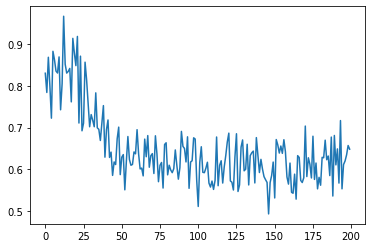

<Figure size 432x288 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt

plt.plot(tmplosslist)
plt.show()
plt.savefig("save.png")

In [18]:
mkrandhistory=[[[3],[[2,3123],[1,2,3]],[3123,3]]]
#yelp
#time=user
#[123,1233,4,5,1]  dense_exp_disp_util?
for mk in mkrandhistory:
     print(mk) 
userdata=Dataset(train_data=False,userhistory=mkrandhistory)
print(userdata)
tests=userdata.data_process_for_placeholder([0])
print("tests...")
with torch.no_grad():
     loss, _, _, _, _, _, _ ,u_disps,_=  model(tests, is_train=True)
print(u_disps)
     #    print(sum_click_u_bar_ut)
     #    loss=-sum_click_u_bar_ut+torch.log(sum_exp_disp_ubar_ut + 1)
     #    print(torch.log(sum_exp_disp_ubar_ut + 1))

[[3], [[2, 3123], [1, 2, 3]], [3123, 3]]
0
tests...
loss : tensor(0.7389)
tensor([[1.5540],
        [1.4391],
        [2.4719],
        [1.5540],
        [2.7440]])


In [ ]:
mkrandhistory=[[[3],[[2,3123,3],[0]],[3123,0]]]
#yelp
#time=user
#[123,1233,4,5,1] 
for mk in mkrandhistory:
     print(mk) 
userdata=Dataset(train_data=False,userhistory=mkrandhistory)
print(userdata)
tests=userdata.data_process_for_placeholder([0])
print("tests...")
with torch.no_grad():
     disp,concat,exp_disp= model.embedding(tests, is_train=True)
     print(disp)
     exp_u_disp = torch.exp(disp)
     print("concat",concat.shape)
print(concats)

[[3], [[2, 3123, 3], [0]], [3123, 0]]


NameError: name 'Dataset' is not defined

In [8]:
#movieset에서 빈값이 있음
#try부분
#이거 채워야 진행이 될듯하네요.

import pandas as pd
df=pd.read_csv("ml-25m.csv")
df=df.drop(['movieId','genres'],axis=1)
movies=df.loc[0:3922].to_dict('list')
movies=movies['title']
moviedict = {}
movieset=[0 for i in range(3952)]
idx2moviedict = {}

movieid=0
for i in range(len(movies)):
    movieid=i
    moviedict[movieid] = movies[i]
    idx2moviedict[movies[i]] = movieid
    movieset[movieid-1]=1
print(moviedict.keys())


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [9]:
movieset

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [16]:
import collections
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
#moviedict를 만듬


#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 5
#[0,[action],[state]]
#1. 유저가 있음.
#유저는 탐색을 해서, 유저를 트레이닝셋에서 가져옴
#파라마티는 너가 추천을 해줄 갯수 5개로 합니다
#s=[]인 유저로 시작
#5개를 추천해줘야함. 추천받아서 
#to choose a set I of k items based on user state s
#유저 시스템은 유저 상태에서 기반해 k로 이루어진 I를 추천해주고 싶어함.
#상태 s(유저가 본 영화)를 제외함 x
#그리고 유저가 본 영화를 제외하고, 
# 3952-x개의 영화속에서 영화를 하나 뽑아서, a1*로 함
#3951-x개의 영화속에서,
#disp가 분포인데...모든 영화를 넣어버리고
#그 영화 feature에서  disp를 가져와서
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst,jlst  = [], [], [], [],[]
        
        for transition in mini_batch:
            s, a, r, s_prime ,j= transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            jlst.append(j)

        return s_lst,a_lst, r_lst, s_prime_lst,jlst
    def size(self):
        return len(self.buffer)

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc11 = nn.Linear(19760, 256)
        self.fc12 = nn.Linear(256, 256)
        self.fc13 = nn.Linear(256, 1)        
        #395x

    def forward(self, x):
        x = F.relu(self.fc11(x))
        x = F.relu(self.fc12(x))
        x = self.fc13(x)
        return x

def train(q1,q2,q3,q4,q5, q_target1,q_target2,q_target3,q_target4,q_target5, memory, optimizer1,optimizer2,optimizer3,optimizer4,optimizer5):
    for i in range(5):
        loss=0
        s_lst,a_lst, r_lst, s_prime_lst,jlst = memory.sample(batch_size)
        for k in range(5): 
            print(a_lst[k])
            sa=[[[0],[],[]]]
            sa[0][1].append([a_lst[k][0],a_lst[k][2],a_lst[k][4]])
            sa[0][1].append([a_lst[k][1],a_lst[k][3]])
            sa[0][2]=[a_lst[k][0],a_lst[k][1]]
            sa=Dataset(train_data=False,userhistory=sa)
            datas=sa.data_process_for_placeholder([0])       
         # print(datas)
            with torch.no_grad():
        #_,disp,_= model.embedding(datas, is_train=True)
                _, _,concat= model.embedding(datas, is_train=True)
            concat=concat.float()

            tmpmovieset2=movieset
            for s in s_prime_lst[k]:
                tmpmovieset2[s]=0
            u=[[0,[[idx] for idx,x in enumerate(tmpmovieset2) if x==1 ],[idx for idx,x in enumerate(tmpmovieset2) if x==1]]]
            sa=Dataset(train_data=False,userhistory=u)
            datas2=sa.data_process_for_placeholder([0])       
         # print(datas)
            with torch.no_grad():
        #_,disp,_= model.embedding(datas, is_train=True)
                _, _,concat2= model.embedding(datas2, is_train=True)
            concat2=concat2.float()

            if jlst[k]==0:
                q_out=q1.forward(concat)
                q_a=q_out[k]
                max_q_prime=q_target1(concat2).max()
                target=r_lst[k]+gamma*max_q_prime
                loss =(target-q_a)**2            
                optimizer1.zero_grad()
                loss.backward(retain_graph=True)
                optimizer1.step()
            if jlst[k]==1:
                q_out=q2.forward(concat)
                q_a=q_out[k]
                #qa=q_out.topk(2)[1]
                max_q_prime=q_target2(concat2).max()
                target=r_lst[k]+gamma*max_q_prime
                loss2 =(target-q_a)**2            
                optimizer2.zero_grad()
                loss2.backward(retain_graph=True)
                optimizer2.step()
            if jlst[k]==2:
                q_out=q3.forward(concat)
                q_a=q_out[k]
                #qa=q_out.topk(3)[2]
                max_q_prime=q_target3(concat2).max()
                target=r_lst[k]+gamma*max_q_prime
                loss3 =(target-q_a)**2            
                optimizer3.zero_grad()
                loss3.backward(retain_graph=True)
                optimizer3.step()
            if jlst[k]==3:
                q_out=q4.forward(concat)
                q_a=q_out[k]
               # qa=q_out.topk(4)[3]
                max_q_prime=q_target4(concat2).max()
                target=r_lst[k]+gamma*max_q_prime
                loss4 =(target-q_a)**2            
                optimizer4.zero_grad()
                loss4.backward(retain_graph=True)
                optimizer4.step()
            if jlst[k]==4:
                q_out=q5.forward(concat)
                q_a=q_out[k]
                #qa=q_out.topk(5)[4]
                max_q_prime=q_target5(concat2).max()
                target=r_lst[k]+gamma*max_q_prime
                loss5 =(target-q_a)**2            
                optimizer5.zero_grad()
                loss5.backward(retain_graph=True)
                optimizer5.step()
        #실제 선택한 action q_out


#sa user가 이미 본 movie
#데이터셋 [1,1,1,1 ] 3923
def casadeQ(saa,q1,q2,q3,q4,q5):
    astar=[]
    #movienum리스트를 3923차원으로 만들고, 값을 죄다 1로 채워넣은 다음, 안되는 건 0으로 만드는 방식
        #state에는 자신이 본 영화만 1
    tmpmovieset=movieset
    for s in saa:
        tmpmovieset[s]=0
    for i in range(5):

        u=[[0,[[idx] for idx,x in enumerate(tmpmovieset) if x==1 ],[idx for idx,x in enumerate(tmpmovieset) if x==1]]]
    #u 유저가 이미 본걸 뺀 영화 전부를 넣음 3800
        sa=Dataset(train_data=False,userhistory=u)
        datas=sa.data_process_for_placeholder([0])       
   # print(datas)
        with torch.no_grad():
        #_,disp,_= model.embedding(datas, is_train=True)
        
            _, _,concat= model.embedding(datas, is_train=True)
        #embedding
        concat=concat.float()
   # print(concat.type)
   # print(concat.shape)
    
        #현상태에 기반해 새로운 인덱스를 만듬
        #q값이 최대인 것을 tmpmovieset에서 하나 뽑고 tmpmovieset에서 추천한거 삭제...
        #i값에 따라 쓰는 파라미터를 변화시켜야됨(3923,3923-1,3923-2,3923-3,3923-4)
        #그럼 len(obs)=i일때는 3923-i-j로 일반화가능
        if i==0:
            out=q1.forward(concat)
            #print(out.shape)
            #print(out)
            aj=torch.argmax(out)
        if i==1:
            out=q2.forward(concat)
            aj=torch.argmax(out)
        if i==2:
            out=q3.forward(concat)
            aj=torch.argmax(out)
        if i==3:               
            out=q4.forward(concat)
            aj=torch.argmax(out)
        if i==4:
            out=q5.forward(concat)
            aj=torch.argmax(out)

        astar.append(aj)
        print(i,":",aj)
        tmpmovieset[aj]=0
    return astar


def main():
    q1 = Qnet()
    q2 = Qnet()
    q3 = Qnet()
    q4 = Qnet()
    q5 = Qnet()
    q_target1 = Qnet()
    q_target2 = Qnet()
    q_target3 = Qnet()
    q_target4 = Qnet()
    q_target5 = Qnet()
    q_target1.load_state_dict(q1.state_dict())
    q_target2.load_state_dict(q2.state_dict())
    q_target3.load_state_dict(q3.state_dict())
    q_target4.load_state_dict(q4.state_dict())
    q_target5.load_state_dict(q5.state_dict())

    memory = ReplayBuffer()

    score = 0.0  
    optimizer1 = optim.Adam(q1.parameters(), lr=learning_rate)
    optimizer2 = optim.Adam(q2.parameters(), lr=learning_rate)
    optimizer3 = optim.Adam(q3.parameters(), lr=learning_rate)
    optimizer4 = optim.Adam(q4.parameters(), lr=learning_rate)
    optimizer5 = optim.Adam(q5.parameters(), lr=learning_rate)
    for n_epi in range(30):
        epsilon =max(0.01, 0.1 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
        # #state 비우기 같은 느낌, user1명에 대해 
        # dataset=Dataset()
        # training_user_nos = np.random.choice(dataset.train_user, 10, replace=False)
        # training_user = dataset.data_process_for_placeholder(training_user_nos)
        for t in range(5):
            s=[]
            for j in range(5):
                coin = random.random()
                if coin<epsilon:
                    print("rand")
                    #movielist에서 무작위로 뽑아서 추천해줌
                    tmp = list(moviedict.keys())
                    randlist = random.sample(tmp,5)
                else:
                    print("cQ")
                    randlist=casadeQ(s,q1,q2,q3,q4,q5)
                #모델에 action을 넣어서 ... st,at,r(s,t),s(t+1)을 구해야되는데
                # st를 임베딩을 해야  
                #movieset에서 빈값이 있음...
                
                sa=[[[0],[],[]]]
                sa[0][1].append([randlist[0],randlist[2],randlist[4]])
                sa[0][1].append([randlist[1],randlist[3]])
                sa[0][2]=[randlist[0],randlist[1]]
                
                sa=Dataset(train_data=False,userhistory=sa)
                tests=sa.data_process_for_placeholder([0])
                u_disp, _, _,= model.embedding(tests, is_train=True)
                    #[1,2,3,4,5]
                    #[?,?,5,?,?]
                #disp는 선택한 값의 reward가 담겨져 있음.
                #r은 disp중에 max
                print(u_disp.shape)
                r=max(u_disp)
                score+=r
                #s_prime은 그 R값의 인덱스가 해당하는 영화의므로, randlist에 가서 찾아 s_prime으로 한다.
                s_p=randlist[torch.argmax(u_disp)]
                print(randlist[torch.argmax(u_disp)])
                s_t=s+[s_p]
                print(s_t)
                #transition=[현상태,액션(추천목록) ,reward,s_t ]
                transition=[s,randlist,r,s_t,j]
                memory.put(transition)
                s=s_t
                print(memory.size())

                if memory.size()%10==0 and n_epi!=0:
                    train(q1,q2,q3,q4,q5, q_target1,q_target2,q_target3,q_target4,q_target5, memory, optimizer1,optimizer2,optimizer3,optimizer4,optimizer5)
                if memory.size()%10==0 and n_epi!=0:
                    q_target1.load_state_dict(q1.state_dict())
                    q_target2.load_state_dict(q2.state_dict())
                    q_target3.load_state_dict(q3.state_dict())
                    q_target4.load_state_dict(q4.state_dict())
                    q_target5.load_state_dict(q5.state_dict())
                    print("epi :",n_epi)
                    print("score",score)
                    #print("n_episode :{}, score : {:.1f}, eps : {:.1f}%".format(n_epi, score/print_interval,  )
                    score = 0.0            

        
           
main()
#250번에 72분...?
#영화가 3952개인 모델인데도 이렇게 오래 걸림

cQ
0
0 : tensor(74)
0
1 : tensor(1041)
0
2 : tensor(32)
0
3 : tensor(2443)
0
4 : tensor(833)
0
torch.Size([5, 1])
tensor(2443)
[tensor(2443)]
1
cQ
0
0 : tensor(72)
0
1 : tensor(1038)
0
2 : tensor(31)
0
3 : tensor(2440)
0
4 : tensor(831)
0
torch.Size([5, 1])
tensor(2440)
[tensor(2443), tensor(2440)]
2
cQ
0
0 : tensor(70)
0
1 : tensor(1035)
0
2 : tensor(30)
0
3 : tensor(2435)
0
4 : tensor(827)
0
torch.Size([5, 1])
tensor(2435)
[tensor(2443), tensor(2440), tensor(2435)]
3
cQ
0
0 : tensor(68)
0
1 : tensor(1031)
0
2 : tensor(29)
0
3 : tensor(2430)
0
4 : tensor(823)
0
torch.Size([5, 1])
tensor(29)
[tensor(2443), tensor(2440), tensor(2435), tensor(29)]
4
cQ
0
0 : tensor(66)
0
1 : tensor(1028)
0
2 : tensor(28)
0
3 : tensor(2427)
0
4 : tensor(821)
0
torch.Size([5, 1])
tensor(1028)
[tensor(2443), tensor(2440), tensor(2435), tensor(29), tensor(1028)]
5
rand
0
torch.Size([5, 1])
1869
[1869]
6
cQ
0
0 : tensor(64)
0
1 : tensor(1025)
0
2 : tensor(27)
0
3 : tensor(2422)
0
4 : tensor(818)
0
torch.Size(

In [ ]:
randlist=[0,1,2,3,4]
sa=[[[0],[],[]]]
sa[0][1].append([randlist[0],randlist[2],randlist[4]])
sa[0][1].append([randlist[1],randlist[3]])
sa[0][2]=[randlist[0],randlist[1]]
print(sa)

[[[0], [[0, 2, 4], [1, 3]], [0, 1]]]


In [ ]:
tmpmovieset=movieset
mkrandhistory=[[[3],[[2,3123],[1,2,3]],[3123,3]]]

u=[[0],[[idx] for idx,x in enumerate(tmpmovieset) if x==1 ],[idx for idx,x in enumerate(tmpmovieset) if x==1]]
for uu in u:
    for uuu in uu[1]:
        print(uuu)
print(")")
sa=Dataset(train_data=False,userhistory=u)
datas=sa.data_process_for_placeholder([0])       
   # print(datas)
with torch.no_grad():
    reward,disp_history_feature,user= model.embedding(datas, is_train=True)
    #데이터셋 리스트를 만들어서 model의 disp값을 받아와야할듯?
disp=disp.float()
print(disp_history_feature.shape)

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[61]
[62]
[63]
[64]
[65]
[66]
[67]
[68]
[69]
[70]
[71]
[72]
[73]
[74]
[75]
[76]
[77]
[78]
[79]
[80]
[81]
[82]
[83]
[84]
[85]
[86]
[87]
[88]
[89]
[91]
[92]
[93]
[94]
[95]
[96]
[97]
[98]
[99]
[100]
[101]
[102]
[103]
[104]
[105]
[106]
[107]
[108]
[109]
[110]
[111]
[112]
[113]
[114]
[115]
[116]
[117]
[118]
[119]
[120]
[121]
[122]
[123]
[124]
[125]
[126]
[127]
[128]
[129]
[130]
[131]
[132]
[133]
[134]
[135]
[136]
[137]
[138]
[139]
[140]
[141]
[142]
[143]
[144]
[145]
[146]
[147]
[148]
[149]
[150]
[151]
[152]
[153]
[154]
[155]
[156]
[157]
[158]
[159]
[160]
[161]
[162]
[163]
[164]
[165]
[166]
[167]
[168]
[169]
[170]
[171]
[172]
[173]
[174]
[175]
[176]
[177]
[178]
[179]
[180]
[181]
[182]
[183]
[184]
[185]

KeyboardInterrupt: 